__Simple walkdown of implementing MLP using MNIST dataset__

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

#### __Model Definition__

In [106]:
class MLP(nn.Module):

    def __init__(self, input_dim = 28*28, hidden_dim = 256, num_classes = 10):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )    

    def forward(self, X):

        X = X.view(X.size(0), -1) # flatten
        return self.model(X)

#### __Dataset & DataLoader__

In [112]:
def get_dataloader(batch_size = 64):

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data',
                                   train=True,
                                   download=True,
                                   transform=transform)
    test_dataset = datasets.MNIST(root='./data',
                                  train=False,
                                  download=True,
                                  transform=transform)
    
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
    
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
    
    return train_loader, test_loader

In [116]:
train_loader, test_loader = get_dataloader(batch_size = 64)

In [ ]:
train, test = get_dataloader()

100%|██████████| 9.91M/9.91M [00:08<00:00, 1.20MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 97.7kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 389kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.62MB/s]


__let's understand data a bit__

In [90]:
classes = train.dataset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [24]:
dataiter = iter(train)
images, lables = next(dataiter)

print(lables[0])
print(images[0])

tensor(3)
tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -

In [31]:
print(images[0].shape)
print(images.shape)

torch.Size([1, 28, 28])
torch.Size([64, 1, 28, 28])


tensor(3)


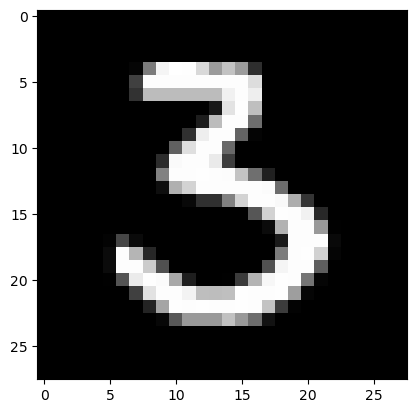

In [35]:
plt.imshow(images[0].reshape(28,28), cmap='grey')
print(lables[0])
plt.show()

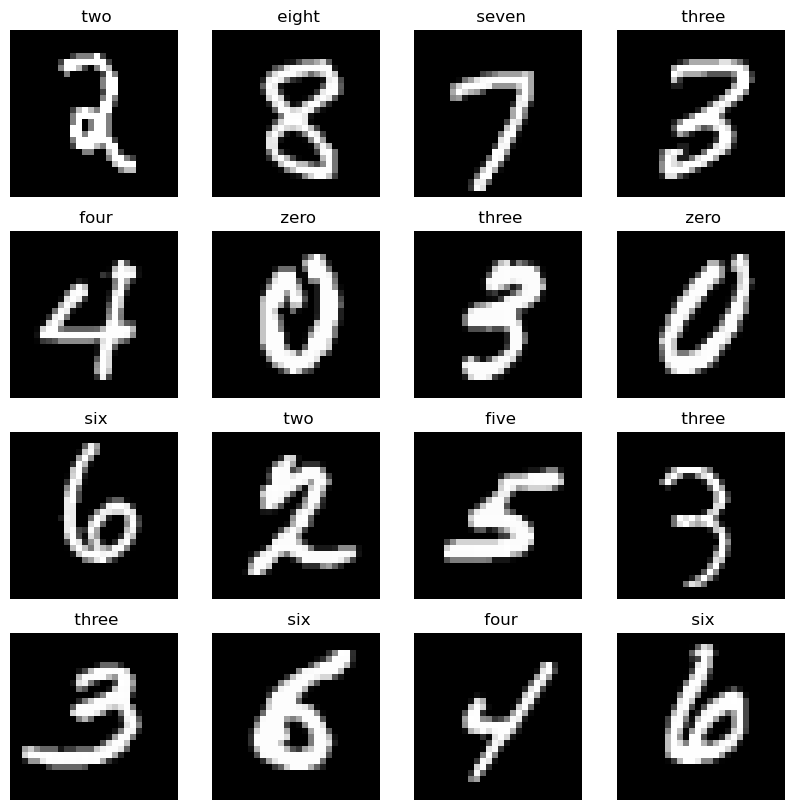

In [97]:
# Let's Plot few more images from the same batch 

torch.manual_seed(42)

fig = plt.figure(figsize=(10,10))
rows, cols = 4, 4

train_iter = iter(train)
for i in range(1, rows * cols + 1):
 
 imgs, lables = next(train_iter)
 random_idx = torch.randint(0, 64, size=[1]).item()
 img, label = imgs[random_idx], lables[random_idx]
 
 fig.add_subplot(rows, cols, i)
 plt.imshow(img.squeeze(), cmap='grey')
 plt.title(classes[label].split('-')[1])
 plt.axis(False);

#### Training Function

In [98]:
def train(model, dataloader, criterion, optimizer, device):

    model.train()
    total_loss = 0.0 

    for images, lables in dataloader:

        images = images.to(device)
        lables = lables.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, lables)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss/ len(dataloader)
    return avg_loss 

#### Testing/Evaluation Function

In [131]:
def test(model, dataloader, criterion, device):

    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, lables in dataloader:
            images = images.to(device)
            lables = lables.to(device)

            outputs = model(images)
            loss = criterion(outputs, lables)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == label).sum().item()
            total += lables.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct / total 

    return avg_loss, accuracy

#### Main Training Loop

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    return torch.device("cpu")


def main():

    '''
    Main code to train Pytorch model
    '''

    device = get_device()
    train_loader, test_loader = get_dataloader(batch_size=64)

    model = MLP().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    epochs = 10

    for epoch in range(epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_loss:.4f} | "
            f"Test Loss: {test_loss:.4f} | "
            f"Test Acc: {test_acc:.2f}%"
        ) 

    torch.save(model.state_dict(), 'mlp_mnist.pt') # saving model once the training is over


In [147]:
if __name__ == '__main__':
    main()

Epoch [1/10] | Train Loss: 0.2216 | Test Loss: 0.1140 | Test Acc: 9.69%
Epoch [2/10] | Train Loss: 0.0903 | Test Loss: 0.1057 | Test Acc: 9.33%
Epoch [3/10] | Train Loss: 0.0629 | Test Loss: 0.0872 | Test Acc: 9.44%
Epoch [4/10] | Train Loss: 0.0491 | Test Loss: 0.0790 | Test Acc: 9.52%
Epoch [5/10] | Train Loss: 0.0392 | Test Loss: 0.0872 | Test Acc: 9.35%
Epoch [6/10] | Train Loss: 0.0343 | Test Loss: 0.0847 | Test Acc: 9.36%
Epoch [7/10] | Train Loss: 0.0296 | Test Loss: 0.0812 | Test Acc: 9.54%
Epoch [8/10] | Train Loss: 0.0242 | Test Loss: 0.0807 | Test Acc: 9.51%
Epoch [9/10] | Train Loss: 0.0214 | Test Loss: 0.0937 | Test Acc: 9.54%
Epoch [10/10] | Train Loss: 0.0262 | Test Loss: 0.0804 | Test Acc: 9.57%


#### Inference

__Making Predictions on the new instances__

torch.Size([28, 28])


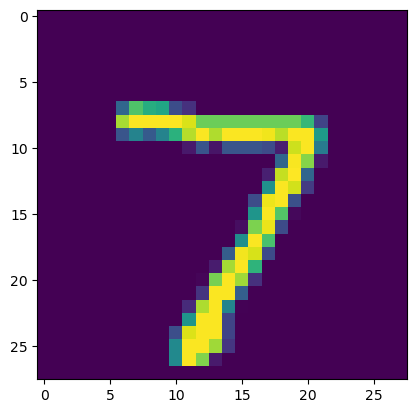

In [144]:
test_image = test_loader.dataset.data[0]

print(test_image.shape)
plt.imshow(test_image)
plt.show()


In [149]:
# creating instance of model and loading the weights 

model_ = MLP()
model_.load_state_dict(torch.load('mlp_mnist.pt', map_location=get_device()))
model_.to(get_device())
model_.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [163]:
print(model_(test_image.unsqueeze(0).to(get_device()).float()))
print(model_(test_image.unsqueeze(0).to(get_device()).float()).argmax(dim=1))

tensor([[-1348.7958,  -232.6040,  -498.2813,    41.2687, -1140.2766, -1473.1091,
         -2234.5796,  1478.3785,  -718.8942,  -694.9771]], device='mps:0',
       grad_fn=<LinearBackward0>)
tensor([7], device='mps:0')


As we can see model has predicted 7 for the given image of 7, so great!

In [202]:
# now let's do batch predictions 


def predict(model, dataloader, device):

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():

        for images, labels in dataloader:
            images = images[0].unsqueeze(0).to(get_device()).float()
            logits = model(images)
            preds = logits.argmax(dim=1)
            all_preds.append(preds)

            label = labels[0]
            all_labels.append(label)

    return torch.cat(all_preds), torch.stack(all_labels)


In [203]:
prediction, actuals = predict(model_, test_loader, get_device())

In [204]:
print(prediction)

tensor([7, 7, 8, 0, 2, 8, 6, 9, 2, 3, 1, 0, 1, 7, 0, 7, 4, 9, 9, 7, 1, 6, 0, 3,
        6, 3, 8, 1, 7, 3, 4, 2, 7, 2, 2, 7, 0, 4, 2, 3, 3, 3, 1, 2, 1, 1, 0, 9,
        8, 7, 9, 1, 7, 9, 3, 4, 0, 1, 6, 8, 9, 2, 5, 1, 8, 6, 7, 3, 3, 6, 9, 4,
        8, 0, 7, 7, 1, 3, 0, 5, 2, 8, 3, 4, 8, 4, 3, 6, 5, 4, 3, 3, 6, 0, 0, 0,
        4, 7, 3, 8, 0, 8, 2, 9, 9, 1, 9, 1, 2, 1, 3, 3, 0, 1, 7, 9, 1, 4, 8, 9,
        9, 7, 5, 8, 3, 4, 7, 1, 5, 6, 2, 8, 0, 7, 0, 9, 2, 1, 4, 6, 4, 2, 8, 4,
        9, 8, 4, 9, 9, 3, 5, 7, 4, 7, 9, 8, 1], device='mps:0')


In [205]:
print(actuals)

tensor([7, 7, 8, 0, 2, 9, 6, 9, 2, 3, 1, 0, 1, 7, 0, 7, 4, 9, 9, 7, 1, 6, 0, 3,
        6, 3, 8, 1, 7, 3, 4, 2, 7, 2, 2, 7, 0, 4, 2, 2, 3, 3, 1, 2, 1, 1, 0, 9,
        8, 7, 9, 1, 7, 9, 3, 6, 0, 1, 6, 5, 9, 2, 5, 1, 8, 6, 9, 3, 3, 6, 9, 4,
        8, 0, 7, 7, 1, 3, 0, 5, 2, 8, 3, 4, 8, 4, 3, 6, 5, 4, 3, 3, 4, 0, 0, 8,
        4, 7, 3, 8, 0, 8, 2, 9, 9, 1, 9, 1, 2, 1, 3, 3, 0, 1, 7, 9, 1, 4, 8, 9,
        9, 7, 5, 8, 3, 4, 7, 1, 5, 6, 2, 8, 0, 7, 0, 9, 2, 1, 4, 6, 4, 7, 8, 4,
        9, 8, 4, 9, 9, 3, 5, 2, 4, 4, 9, 8, 1])


In [207]:
accuracy = (prediction.cpu() == actuals).sum().item() / len(actuals) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 93.63%


__Things to implement__ 

1. Scale training to multiple devices (Distributed Training).
2. Modularize the code into separate .py files.
     - Implement a CNN and compare its performance.
3. Pass images of handwritten digits to the model and evaluate its performance.
4. Export the best model and build a simple Android application (Vibe code) with the following functionalities:
     -  Simple, light-colored UI.
     - Option to upload an image or take a picture.
     - Perform inference on the image and return the result.

-----

__Implementing 2D Convolution in PyTorch__